## Import and define

## difference in bigcode and slim

1. ngram =>
   slim uses: ngrams(content, ngram_size)
   bigcode uses: ngrams(NON_ALPHA.split(content), ngram_size)

2. permuations =>
   slim generate permutation by datasketch
   bigcide generate permutation its self.

In [5]:
import argparse
import os
import sys
import ftfy
import pyspark.sql.functions as F
import shutil

cur_path = "/home/vmagent/app/"

modelzoo_path = os.path.join(cur_path, "modelzoo")
print(modelzoo_path)
bigcode_path = os.path.join(cur_path, "bigcode-dataset/near_deduplication/")
print(bigcode_path)
! cp -r {modelzoo_path}/modelzoo/transformers/data_processing/slimpajama/dedup /usr/local/lib/python3.10/dist-packages/
! cp {bigcode_path}/minhash_deduplication_spark.py /usr/local/lib/python3.10/dist-packages/
sys.path.append(modelzoo_path)
sys.path.append(bigcode_path)

from dedup import generate_connected_components, generate_duplicates_dict, to_hash
from dedup.to_hash import *
from datasketch import MinHash
from datasketch.lean_minhash import LeanMinHash
from minhash_deduplication_spark import *
from datasketch.hashfunc import sha1_hash32 as datasketch_sha1_hash32

def normalize_str(s):
    print("original:", s)
    s = ftfy.fix_text(s, normalization="NFC")
    s = s.lower().translate(str.maketrans("", "", string.punctuation))
    s = re.sub(r"\s+", " ", s.strip())
    return s

def generate_hash_values_slimpj(content, idx, num_perm, ngram_size, hashranges, permutations, min_ngram_size):
    # 0. apply normalization to content
    content = normalize_str(content)
    print("after normalize: ", content)
    #tokens = {" ".join(t) for t in ngrams(content, ngram_size)}
    print("after split:", NON_ALPHA.split(content))
    tokens = {" ".join(t) for t in ngrams(NON_ALPHA.split(content), ngram_size)}
    print("after tokenize w/ split:", tokens)
    print("after tokenize wo split:", {" ".join(t) for t in ngrams(content, ngram_size)})
    
    #1. using bigcode impl to calculate minHash
    m = MinHash(num_perm=num_perm, permutations = permutations, hashfunc = sha1_hash32)
    m.update_batch([token.encode("utf-8") for token in tokens])

    print(m.hashvalues.shape)
    print(m.hashvalues)
    
    #2. map results to each band
    Hs = [bytes(m.hashvalues[start:end].byteswap().data) for start, end in hashranges]
    return [(band_idx, H, idx) for band_idx, H in enumerate(Hs)]

def generate_hash_values_bigcode(content, idx, num_perm, ngram_size, hashranges, permutations, min_ngram_size):
    #0. apply normalize to content
    content = normalize_str(content)
    tokens = {" ".join(t) for t in ngrams(NON_ALPHA.split(content), ngram_size, min_ngram_size)}
    
    #1. using bigcode impl to calculate minHash    
    a, b = permutations
    hashvalues = np.ones(num_perm, dtype=np.uint64) * MAX_HASH
    hv = np.array([sha1_hash32(token.encode("utf-8")) for token in tokens], dtype=np.uint64)
    phv = np.bitwise_and(((hv * np.tile(a, (len(hv), 1)).T).T + b) % MERSENNE_PRIME, MAX_HASH)
    hashvalues = np.vstack([phv, hashvalues]).min(axis=0)
    
    print(hashvalues.shape)
    print(hashvalues)
    
    #2. map results to each band
    Hs = [bytes(hashvalues[start:end].byteswap().data) for start, end in hashranges]
    return [(band_idx, H, idx) for band_idx, H in enumerate(Hs)]

def get_permutation(threshold, num_perm, B = None, R = None):
    if B is None or R is None:
        B, R = optimal_param(threshold, num_perm)
    HASH_RANGES = [(i * R, (i + 1) * R) for i in range(B)]
    PERMUTATIONS = np.array(
        [
            (
                RNG.randint(1, MERSENNE_PRIME, dtype=np.uint64),
                RNG.randint(0, MERSENNE_PRIME, dtype=np.uint64),
            )
            for _ in range(num_perm)
        ],
        dtype=np.uint64,
    ).T
    return HASH_RANGES, PERMUTATIONS, B, R

def read_json(data_files):
    from pyspark.sql.functions import input_file_name
    from pyspark.sql.types import StructType,StructField, StringType
    schema = StructType([ 
        StructField("text",StringType(),True), 
        StructField("meta",StringType(),True)
      ])

    first = True
    for filename in data_files:
        print(filename)
        df = spark.read.text(filename)
        df = df.withColumn('jsonData', F.from_json(F.col('value'), schema)).select("jsonData.*")
        df = df.withColumn("__id__", F.monotonically_increasing_id())
        df = df.withColumn("filename", F.lit(os.path.basename(filename)))
        df = df.withColumn("filename_docid", F.concat_ws("@", "filename", "__id__"))
        df = df.select("filename_docid", "text", "meta")
        if first:
            first = False
            ret_df = df
        else:
            ret_df = ret_df.union(df)
    return ret_df

def convert_to_slimPJ_fmt(first, second):
    return [f"{first} :: {second}"]


/home/vmagent/app/modelzoo
/home/vmagent/app/bigcode-dataset/near_deduplication/


## Configurate DIR

In [6]:
import jsonlines
data_files = ["/home/vmagent/app/test_data/stackexchange_sample.jsonl"]

# ported implementation from slim, very different
# Define parameters
ngram_size = 5
num_perm = 256
threshold = 0.7
min_ngram_size = 5
B = None
R = None
# defined in SlimPajama Main.py
B = 9
R = 13
num_perm = 128

HASH_RANGES, PERMUTATIONS, num_bands, ranges = get_permutation(threshold, num_perm, B, R)
print(f"num_bands is {num_bands}, ranges is {ranges}")

def get_documents(file_path):
    with jsonlines.open(file_path) as rdr:
        for doc_id, doc in enumerate(rdr):
            yield doc["text"], file_path, doc_id

content_list = []
print("!!! using slimPJ !!!")
for doc in get_documents(data_files[0]):
    content, file_path, doc_id = doc
    ret_slimpj = generate_hash_values_slimpj(content=content,
            idx=f"{file_path}@{doc_id}",
            num_perm=num_perm,
            ngram_size=ngram_size,
            hashranges=HASH_RANGES,
            permutations = PERMUTATIONS, 
            min_ngram_size = min_ngram_size)
    break

print("!!! using bigcode !!!")
for doc in get_documents(data_files[0]):
    content, file_path, doc_id = doc
    ret_bigcode = generate_hash_values_bigcode(content=content,
            idx=f"{file_path}@{doc_id}",
            num_perm=num_perm,
            ngram_size=ngram_size,
            hashranges=HASH_RANGES,
            permutations = PERMUTATIONS, 
            min_ngram_size = min_ngram_size)
    break

for idx in range(len(ret_slimpj)):
        print(idx)
        print("slimpj hash")
        print(ret_slimpj[idx])
        print("bigcode hash")
        print(ret_bigcode[idx])


num_bands is 9, ranges is 13
!!! using slimPJ !!!
original: Q: How to modify non-configurable, non-writable properties in Javascript? I'm writing a simple EventEmitter is ES5.
The objective is to ensure that all properties on EventEmitter instances are
non-writable and non-configurable."
After 6 hours of racking my brain I still can't figure out how to, increase the listenerCount, for example if the configurable descriptor is set to false.
Here's an example of what I have:
var eventEmitter = function(){
  var listeners = listeners || 0;
  var events = events || {};

  Object.defineProperties(this, {
   listeners: {
    value : 0,
    configurable: false,
    writable: false
  },
  events: {
    value: {},
    configurable : false,
    writable: false
    }
  });
  return this;
};


eventEmmitter.prototype.on = function(ev, cb) {
  if (typeof ev !== 'string') throw new TypeError("Event should be type string", "index.js", 6);
  if (typeof cb !== 'function' || cb === null || cb === undefi

### Calulate minHashLSH

reference is https://huggingface.co/blog/dedup#locality-sensitive-hashing

### 1. step 1: gen minHash for doc_bands

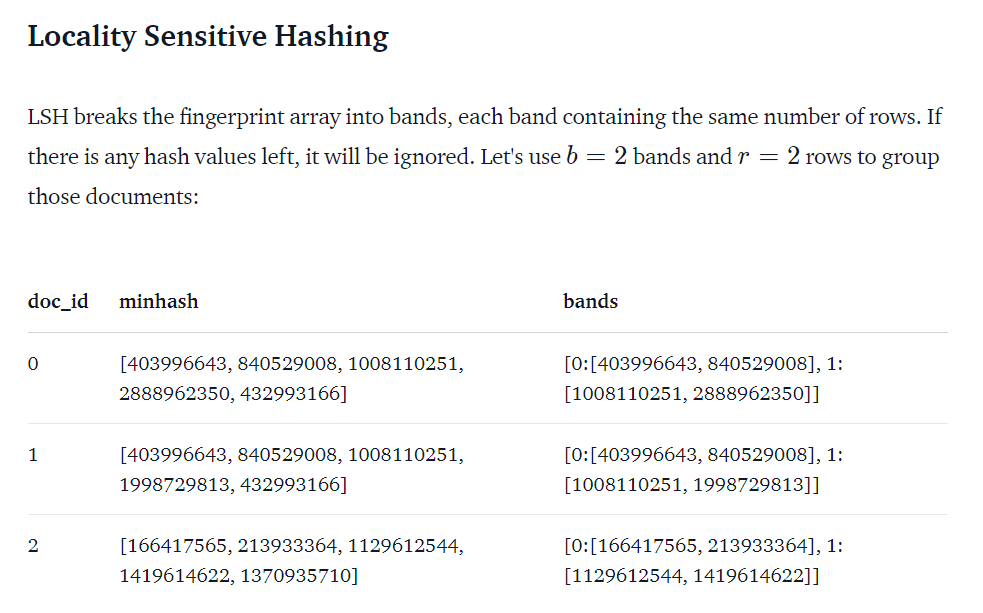

### 2. Step2: gen edges

Once we have the band_index, hash of the band and doc_ids, we need to find which docs are sharing band_index and band_value
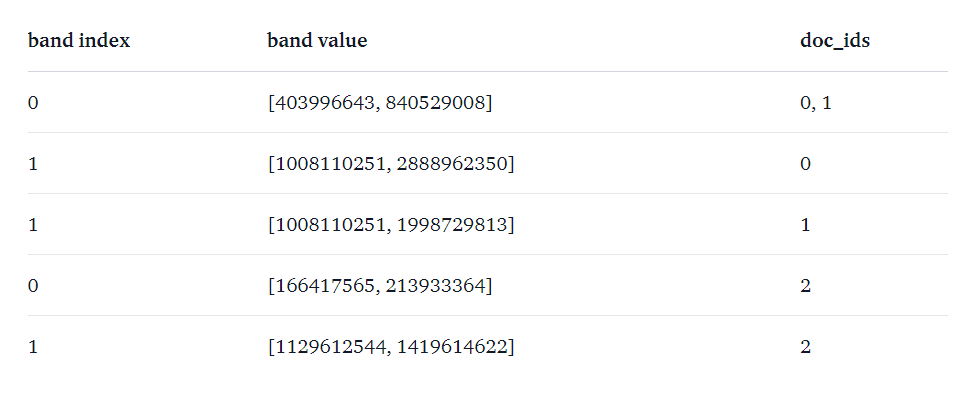

In [7]:
## ported implementation from slim, very different
# # Define parameters
# ngram_size = 5
# num_perm = 256
# threshold = 0.7
# min_ngram_size = 5

# HASH_RANGES, PERMUTATIONS, num_bands, ranges = get_permutation(threshold, num_perm)
# print(f"num_bands is {num_bands}, ranges is {ranges}")

# # group_by(x[0], x[1]) => band_idx, hash value
# # flatMap(x[1]) => a list of tuple(band_idx, hash value, doc_id) shares same (band_idx, hash value)
# # generate_edges(i[2]) input is doc_idx
# pipeline = (
#     df.rdd.flatMap(
#         lambda x: generate_hash_values_slimpj(
#             content=x[1],
#             idx=x[0],
#             num_perm=num_perm,
#             ngram_size=ngram_size,
#             hashranges=HASH_RANGES
#         )
#     )
#     .cache()
#     .groupBy(lambda x: (x[0], x[1]))
#     .flatMap(lambda x: generate_edges([(i[2]) for i in x[1]]))
#     .flatMap(lambda x: convert_to_slimPJ_fmt(x[0], x[1]))
#     .distinct()
#     .cache()
# )

# with Timer("generate minHashLsh Edges"):
#     if os.path.exists(dup_dir):
#          shutil.rmtree(dup_dir, ignore_errors=True)
#     results = pipeline.saveAsTextFile(dup_dir)


In [8]:
# # Define parameters
# ngram_size = 5
# num_perm = 256
# threshold = 0.7
# min_ngram_size = 5
# B = None
# R = None
# # defined in SlimPajama Main.py
# B = 9
# R = 13
# num_perm = 128

# HASH_RANGES, PERMUTATIONS, num_bands, ranges = get_permutation(threshold, num_perm, B, R)
# print(f"num_bands is {num_bands}, ranges is {ranges}")

# # group_by(x[0], x[1]) => band_idx, hash value
# # flatMap(x[1]) => a list of tuple(band_idx, hash value, doc_id) shares same (band_idx, hash value)
# # generate_edges(i[2]) input is doc_idx
# pipeline = (
#     df.rdd.flatMap(
#         lambda x: generate_hash_values_bigcode(
#             content=x[1],
#             idx=x[0],
#             num_perm=num_perm,
#             ngram_size=ngram_size,
#             hashranges=HASH_RANGES,
#             permutations = PERMUTATIONS, 
#             min_ngram_size = min_ngram_size
#         )
#     )
#     .cache()
#     .groupBy(lambda x: (x[0], x[1]))
#     .flatMap(lambda x: generate_edges([(i[2]) for i in x[1]]))
#     .flatMap(lambda x: convert_to_slimPJ_fmt(x[0], x[1]))
#     .distinct()
#     .cache()
# )

# with Timer("generate minHashLsh Edges"):
#     if os.path.exists(dup_dir):
#          shutil.rmtree(dup_dir, ignore_errors=True)
#     results = pipeline.saveAsTextFile(dup_dir)
